## Supporting stable matrix approximation [paper](http://jmlr.org/proceedings/papers/v48/lib16.pdf) experiments

### Main idea of this paper is following: let's take hard predictable enties of a given matrix and increase it's weights in objective function. By hard predictable here we mean entries with higher, than average, error of approximation.

### In general, we'll split data into training and test set, learn factors with training set and look on errors of approximation

In [1]:
from __future__ import division, print_function
from svd_improvement import *
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix
from scipy.linalg import svd, diagsvd
from scipy.sparse.linalg import svds
import matplotlib.pyplot as plt
%matplotlib inline
seed = 417

### Loading data. MovieLens (1M) dataset can be founded [here](http://files.grouplens.org/datasets/movielens/ml-1m.zip)

In [6]:
ratings, users, movies = load_data()
# full matrix is relatively small, so it can be fitted in RAM
R = construct_full_matrix(ratings, users, movies, mode='dense')
train_mask, test_mask = get_train_test_masks(ratings, users, movies)

In [121]:
R.shape

(6040, 3883)

In [132]:
np.linalg.matrix_rank(R)

3513

### Despite matrix has a rather high rank, let's try proposed algorithm for different approximation ranks

In [94]:
errors_train = []
errors_test = []
errors_train_impr = []
errors_test_impr = []
k_list = 2 ** np.arange(12)

for k in k_list:
    U, s, Vh = svds(csr_matrix(R * train_mask), k=k)
    Sigma = np.zeros((U.shape[1], Vh.shape[0]))
    Sigma[range(len(s)), range(len(s))] = s
    V = np.dot(Vh.T, Sigma.T)
    U_impr, V_impr = improve_approximation(R.values, U, V, 0.7, rank, np.ones(4))
    errors_train_impr.append(rmse(R, np.dot(U_impr, V_impr.T), mask=train_mask))
    errors_test_impr.append(rmse(R, np.dot(U_impr, V_impr.T), mask=test_mask))
    print('Approximation error for k = {} computed'.format(k))

Approximation error for k = 1 computed
Approximation error for k = 2 computed
Approximation error for k = 4 computed
Approximation error for k = 8 computed
Approximation error for k = 16 computed
Approximation error for k = 32 computed
Approximation error for k = 64 computed
Approximation error for k = 128 computed
Approximation error for k = 256 computed
Approximation error for k = 512 computed
Approximation error for k = 1024 computed
Approximation error for k = 2048 computed


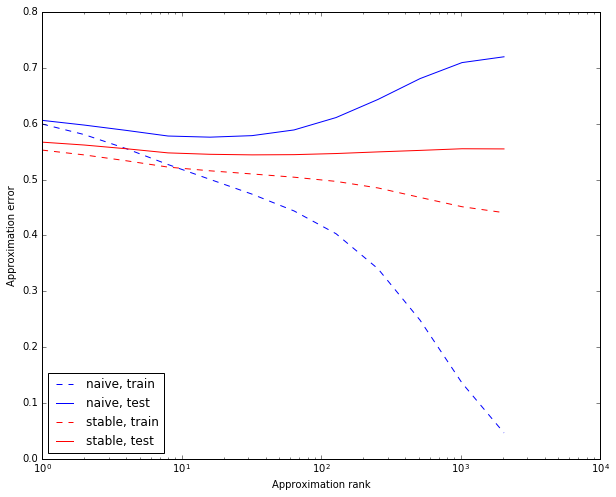

In [122]:
plt.figure(figsize=(10, 8))
plt.plot(k_list, errors_train, 'b--')
plt.plot(k_list, errors_test, 'b')
plt.plot(k_list, errors_train_impr, 'r--')
plt.plot(k_list, errors_test_impr, 'r')
plt.legend(['naive, train', 'naive, test', 'stable, train', 'stable, test'], loc='lower left')
plt.xscale('log')
plt.xlabel('Approximation rank')
plt.ylabel('Approximation error')
plt.show()

### As we observe, obtained by stable procedure test error is uniformly less. Now, let's look on error behavior during iterations of stochastic gradient descent. We'll slightly modify functions

In [115]:
diff_errors_train = []
diff_errors_test = []

def minimize_final_objective(R, U_0, V_0, hard_pred_indices, lambdas, lr=1.0, reg_U=0.06, reg_V=0.06, max_iter=15):
    U_old, V_old = U_0, V_0
    error_train = rmse(R, np.dot(U_0, V_0.T), mask=train_mask)
    error_test = rmse(R, np.dot(U_0, V_0.T), mask=test_mask)
    
    for iter_num in range(max_iter):
        U, V = U_old.copy(), V_old.copy()
        diff = np.dot(U, V.T) - R
        
        for k in range(lambdas.shape[0]):  # K+1
            approx_error_masked = np.sum(np.power(diff * hard_pred_indices[k], 2)) / np.sum(hard_pred_indices[k])
            shared_factor = lr * lambdas[k] / (approx_error_masked * np.sum(hard_pred_indices[k]))
            U -= shared_factor * np.dot(diff * hard_pred_indices[k], V_old)
            V -= shared_factor * np.dot((diff * hard_pred_indices[k]).T, U_old)
        
        U -= lr * reg_U * U
        V -= lr * reg_V * V
        U_old, V_old = U, V
        # the only difference with original function in following 2 lines
        diff_errors_train.append(error_train - rmse(R, np.dot(U, V.T), mask=train_mask))
        diff_errors_test.append(error_test - rmse(R, np.dot(U, V.T), mask=test_mask))
    
    return U, V


def improve_approximation(R, U_old, V_old, choice_prob, rank, lambdas):
    R_appr = np.dot(U, V.T)
    av_error = rmse(R, R_appr)
    rho_mask = np.random.rand(*R.shape) <= choice_prob
    diff_mask = np.abs(R - R_appr) <= av_error
    easy_pred_indices = np.logical_not(np.logical_xor(rho_mask, diff_mask))
    nnz_entries = np.zeros(R.shape, dtype=bool)
    nnz_entries[np.where(R)] = True
    hard_pred_indices = np.logical_xor(nnz_entries[np.newaxis, :, :], divide_set(easy_pred_indices, lambdas.shape[0]-1))
    return minimize_final_objective(R, U_old, V_old, hard_pred_indices, lambdas)

In [116]:
U, s, Vh = svds(csr_matrix(R * train_mask), k=2**7)
Sigma = np.zeros((U.shape[1], Vh.shape[0]))
Sigma[range(len(s)), range(len(s))] = s
V = np.dot(Vh.T, Sigma.T)
U_impr, V_impr = improve_approximation(R.values, U, V, 0.7, rank, np.ones(4))

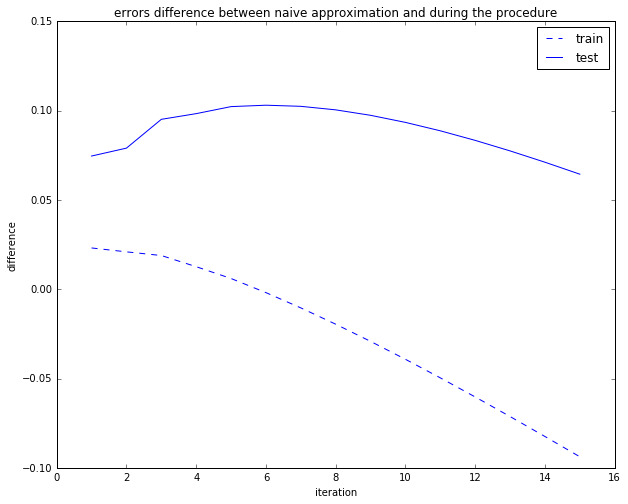

In [123]:
plt.figure(figsize=(10, 8))
plt.plot(range(1, len(diff_errors_train)+1), diff_errors_train, 'b--')
plt.plot(range(1, len(diff_errors_test)+1), diff_errors_test, 'b')
plt.legend(['train', 'test'])
plt.ylabel('difference')
plt.xlabel('iteration')
plt.title('errors difference between naive approximation and during the procedure')
plt.show()

### From the very first iteration stable procedure increases generalization performance of approximation